# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [2]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [5]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**2) Check the shape of images and targets.**

In [20]:
print("Shape of the images:", x_train[0].shape)
print("Shape of the targets:", y_train[0].shape)

Shape of the images: (32, 32, 3)
Shape of the targets: (1,)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [9]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

In [6]:
x_train = x_train/255
x_test  = x_test/255

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [7]:
y_train = to_categorical(y_train, num_classes=10, dtype='int')
y_test  = to_categorical(y_train, num_classes=10, dtype='int')

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

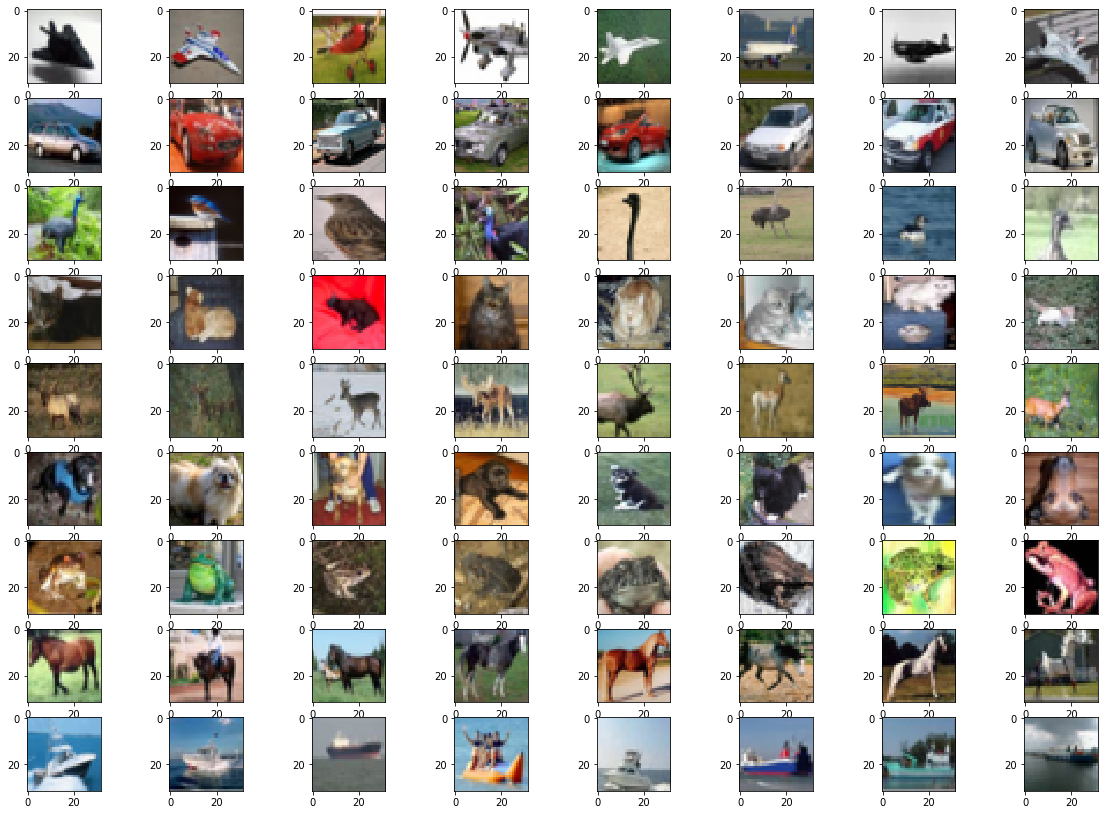

In [24]:
%matplotlib inline

(x_train_1, y_train_1), (x_test_1, y_test_1) = cifar10.load_data()

fig = plt.figure(figsize=(20, 16))
index=0

for i in range(9): #loop over classes
    nb_img = 0
    j = -1
    
    while nb_img<8:
        j+=1
        if y_train_1[j]==i:
            index+=1
            fig.add_subplot(10, 8, index)
            plt.imshow(x_train[j])
            nb_img+=1
plt.show()

# plt.tight_layout()

The following code summarizes the previous operations. 

In [3]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    x_train = x_train/255
    x_test  = x_test/255
    y_train = to_categorical(y_train, num_classes=10, dtype='int')
    y_test  = to_categorical(y_train, num_classes=10, dtype='int')    
    return x_train, y_train, x_test, y_test, labels

x_train, y_train, x_test, y_test, labels = load_cifar_data()

def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    
    (x_train_1, y_train_1), (x_test_1, y_test_1) = cifar10.load_data()
    fig = plt.figure(figsize=(20, 16))
    index=0

    for i in range(9): #loop over classes
        nb_img = 0
        j = -1

        while nb_img<8:
            j+=1
            if y_train_1[j]==i:
                index+=1
                fig.add_subplot(10, 8, index)
                plt.imshow(x_train[j])
                nb_img+=1
    plt.show()

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

show_first_n_images_in_categories(8, x_train, y_train, labels, file_name = None)

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [25]:
def dense_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape, name='flatten'))
    
    model.add(Dense(2048, activation='relu', name='dense_relu_1'))
    model.add(Dense(1024, activation='relu', name='dense_relu_2'))
    model.add(Dense(512, activation='relu', name='dense_relu_3'))
    model.add(Dense(256, activation='relu', name='dense_relu_4'))
    
    model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    return model

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

Dimension of each flattened image is $32*32*3 = 3072$

* Number of parameters in the 1st dense layer is $(3072+1)*2048 = 6293504$ (the +1 corresponds to the bias)
* Number of parameters in the 2nd dense layer is $(2048+1)*1024 = 2098176$
* Number of parameters in the 3rd dense layer is $(1024+1)*512 = 524800$
* Number of parameters in the 4th dense layer is $(512+1)*256 = 131328$
* Number of parameters in the output layer is $(256+1)*10 = 2570$

As a result, total number of parameters is **9,050,378** (sum of all previous).

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [26]:
input_shape = x_train[0].shape
num_classes = len(labels)
model = dense_model(input_shape, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense_relu_1 (Dense)         (None, 2048)              6293504   
_________________________________________________________________
dense_relu_2 (Dense)         (None, 1024)              2098176   
_________________________________________________________________
dense_relu_3 (Dense)         (None, 512)               524800    
_________________________________________________________________
dense_relu_4 (Dense)         (None, 256)               131328    
_________________________________________________________________
dense_softmax (Dense)        (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
_________________________________________________________________


**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [27]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the model on the given data.
    """
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1)
    return ret

dense_model = train_model(model, x_train, y_train)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
12768/50000 [======>.......................] - ETA: 8:10 - loss: 1.9987 - acc: 0.2775- ET

KeyboardInterrupt: 

In [ ]:
performance = dense_model.model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', performance[0])
print('Test accuracy:', performance[1])

**11) Plot several images with their predictions. Any comment?**

<function matplotlib.pyplot.show(*args, **kw)>

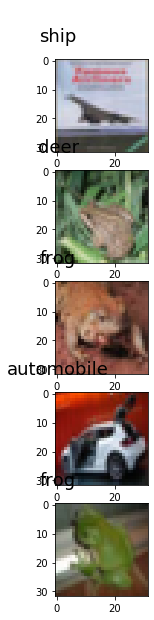

In [11]:
dense_model = load_model('final_dense.h5')

fig = plt.figure(figsize=(20, 16))

ynew = dense_model.predict_classes(x_test)
# show the inputs and predicted outputs
index=1
for i in range(3,8):
    fig.add_subplot(8, 1, index)
    plt.text(0.5, 0.5, '\n'+labels[ynew[i]]+'\n',
             fontsize=18, ha='center')
    plt.imshow(x_test[i])
    index+=1
plt.show
    #print("X=%s, Predicted=%s" % (x_test[i], ynew[i]))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

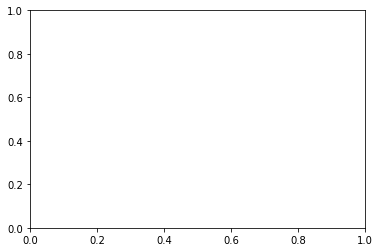

In [48]:
predictions = dense_model.predict(x_test[3:8,:,:,:])
plt.bar(x = range(5), height = predictions[i:], tick_label=labels)

<function matplotlib.pyplot.show(*args, **kw)>

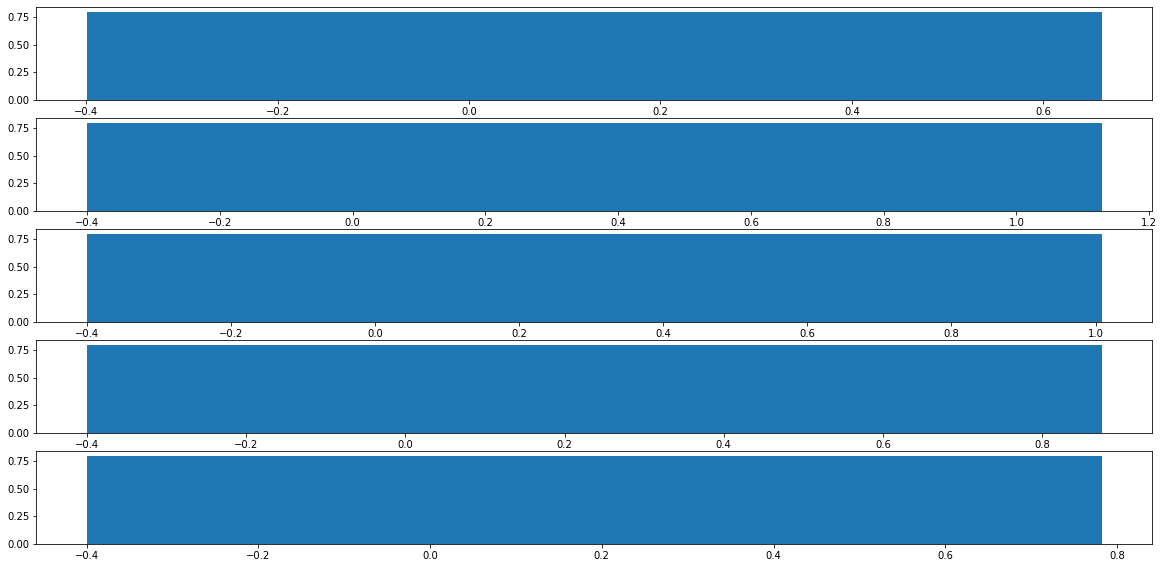

In [69]:
import seaborn as sns
index=1
fig = plt.figure(figsize=(20, 16))
predictions = dense_model.predict(x_test[3:8,:,:,:])
for i in range(5):
    fig.add_subplot(8, 1, index)
    plt.bar(predictions[i], height=0.8)
    plt.yticks(np.arange(10))
    index+=1
plt.show

In [63]:
labels[argmax(predictions[1])]

NameError: name 'argmax' is not defined

Comments: 

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [14]:
def cnn_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same', name='conv_1'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pooling_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_3'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_4'))
    model.add(MaxPooling2D(pool_size=(2,2), name='pooling_2'))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dense(output_dim = 10, activation='softmax', name='output'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    
    return model

model = cnn_model(x_train.shape[1:], 10)

/Users/Thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", name="output", units=10)`
  del sys.path[0]


**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

- First Convolutional layer:  $32*9*3+32 = 896$
- Second Convolutional layer: $(32 * 3 * 3 + 1) * 32 = 9248$
- First Max Pooling: this layer is used to reduce the input image size. Kernal_size = (2,2) used here, so input image 96 is reduced to half: 48. Model learns nothing from this layer (no parameters).
- Third Convolutional layer:  $(3 * 3 * 32 + 1) * 64 = 18496$
- Fourth Convolutional layer:  $(3 * 3 * 64 + 1) * 64 = 36928$
- Dense (fully connected) layer: $512 * (4096+1) = 2097664$ (4096 inputs from Flatten layer, 512 outputs to last layer)
- Last (output) layer: $10 * (512 + 1) =5130$ 

As a result, total number of parameters is **2,168,362** (sum of all previous).

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 16, 16, 64)        36928     
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [9]:
def train_cnn(model, x, y, batch_size=32, epochs=10, file_name=None):
    """
    Trains the cnn model on the given data.
    """
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1)
    return ret

cnn_model = train_cnn(model, x_train, y_train)

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

Batch size is the number of samples from the training dataset used to perform the stochastic gradient descent optimization. Usinf the whole training dataset is not computationaly efficient. Using only 1 single sample for the gradient updates could decrease accuracy as the sample might be noisy (not a good representation of the whole data).

What we found in literature is that we usually choose a default size of 32 or 64:  

> "… [batch size] is typically chosen between 1 and a few hundreds, e.g. [batch size] = 32 is a good default value" — _Practical recommendations for gradient-based training of deep architectures_ , 2012.  

> "The presented results confirm that using small batch sizes achieves the best training stability and generalization performance, for a given computational cost, across a wide range of experiments. In all cases the best results have been obtained with batch sizes m = 32 or smaller, often as small as m = 2 or m = 4." — _Revisiting Small Batch Training for Deep Neural Networks_ , 2018.

In [1]:
# As an example - training of our CNN with batch_size = 1 :
# cnn_model = train_cnn(model, x_train, y_train, batch_size = 1)

**Conclusions** : on our computer (MacBook Pro 2016), with batch_size=32 training duration is around 4 minutes per epoch, which looks like a good performance ocmpared to other values we tested. With batch_size = 100, training is a little longer, around 5min/epoch. With batch_size = 1000, it's again a little longer, around 6 min/epoch. With batch_size = 1, it's much longer, around 10 min/epoch.

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

This phenomenon is **overfitting**, i.e. at some point the model describes our training data better and better but is less performant on generalization.

In [14]:
# Adding dropout layers

def cnn_dropout(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same', name='conv_1'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_2'))
    model.add(Droupout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2), name='pooling_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_3'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_4'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2), name='pooling_2'))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.25))
    model.add(Dense(output_dim = 10, activation='softmax', name='output'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    
    return model

model_dropout = cnn_dropout(x_train.shape[1:], 10)

In [ ]:
cnn_dropout = train_cnn(model_droupout, x_train, y_train)

Conclusion:


What is Batch Normalization?
First introduced in the paper: Accelerating Deep Network Training by Reducing Internal Covariate Shift. 

As the data flows through a deep network, the weights and parameters adjust those values, sometimes making the data too big or too small again - a problem the authors refer to as "internal covariate shift". By normalizing the data in each mini-batch, this problem is largely avoided. Batch Normalization normalizes each batch by both mean and variance reference.

Benefits of Batch Normalization
Networks train faster converge much more quickly,
Allows higher learning rates. Gradient descent usually requires small learning rates for the network to converge.
Makes weights easier to initialize
Makes more activation functions viable. Because batch normalization regulates the values going into each activation function, non-linearities that don't seem to work well in deep networks actually become viable again.
May give better results overall.

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [15]:
# Adding batch normalization before dropout layers

def cnn_norm(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same', name='conv_1'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_2'))
    model.add(Droupout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2), name='pooling_1'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_3'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_4'))
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2), name='pooling_2'))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='dense_1'))
    model.add(Dropout(0.25))
    model.add(Dense(output_dim = 10, activation='softmax', name='output'))
    
    model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])
    
    return model

model_norm = cnn_norm(x_train.shape[1:], 10)

In [ ]:
cnn_norm = train_cnn(model_norm, x_train, y_train)

Conclusion:

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

In [16]:
def predict(model, x, labels, file_name=None):
    model.predict(x)
    
    fig = plt.figure(figsize=(20, 16))
    index=0

    for i in range(9): #loop over classes
        nb_img = 0
        j = -1

        while nb_img<8:
            j+=1
            if y_train_1[j]==i:
                index+=1
                fig.add_subplot(10, 8, index)
                plt.imshow(x_train[j])
                nb_img+=1
    plt.show()


    
    
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

predict(model, x_test[3:8,:,:,:], labels, file_name="predictions.png")

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [17]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    
# 1.Predict class
# Get true class and class labels

true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# 4. Use scikit-learn to get confusion matrix

import sklearn.metrics as metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

# or

y_pred_ohe = KerasClassifier.predict(X)  # shape=(n_samples, 10 classes)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)  # shape=(10, 10)


<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks (Bonus !)

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [72]:
# Import pre-trained model

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=x_train.shape[1:])


58892288/58889256 [==============================] - 51s 1us/step


In [73]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

### 1st method (less expensive)
Running the convolutional base over our dataset, recording its output to a Numpy array on disk (with the `predict` method), then using this data as input to train a standalone densely-connected classifier with 2 layers. This doesn't allow to leverage data augmentation, as we 

In [ ]:
# predict and store the output of conv_base on our data

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

In [ ]:
# flatten to obtain input for dense layers

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [ ]:
# define and fit our dense classifier

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

In [ ]:
# test performance

# we can plot the loss and accuracy curves:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2nd method (more expensive)
Extending the `conv_base` model by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 

In [77]:
# define the full model

model_pretrained = Sequential()
model_pretrained.add(conv_base)
model_pretrained.add(Flatten())
model_pretrained.add(Dense(512, activation='relu'))
model_pretrained.add(Dense(10, activation='softmax'))
model_pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 14,982,474
Non-trainable params: 0
_________________________________________________________________


In [78]:
# freeze the pre-trained conv layers for training

print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_pretrained.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model_pretrained.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [ ]:
# train the model on our data

model.compile(loss=categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
# plot performance

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Fine-tuning ? (not really needed)

#### Comments: comparison with our previous models